In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
wid = "W0204-0506"

In [4]:
#Load the properties of the BHDs
op = ObjectProperties([wid])

In [5]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [6]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra([wid])

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [7]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pws = dict()
cone_types = ["Top", "Bottom"]
for cone_type in cone_types:
    pws[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method='pchip')

pws_linear = dict()
for cone_type in cone_types:
    pws_linear[cone_type] = LoadSKIRTOR_MRN77(cone_type=cone_type, interp_method='linear')

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

chi2_map[wid] = dict()
for cone_type in cone_types:
    fname = "maps_{}Cone/chi2_map_{}.fits".format(cone_type, wid)
    h = fits.open(fname)
    tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
    tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
    cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
    cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
    iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
    iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
    chi2_map[wid][cone_type] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
    chi2_map[wid][cone_type][:,:,:] = h[0].data
    chi2_map[wid][cone_type].mask = h[1].data.astype(bool)


In [8]:
#Find the best solution for W0204-0506
for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid][cone_type].min())

32.5 deg 21.0 deg 56.0 deg 7.689583731337499e-10
50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08


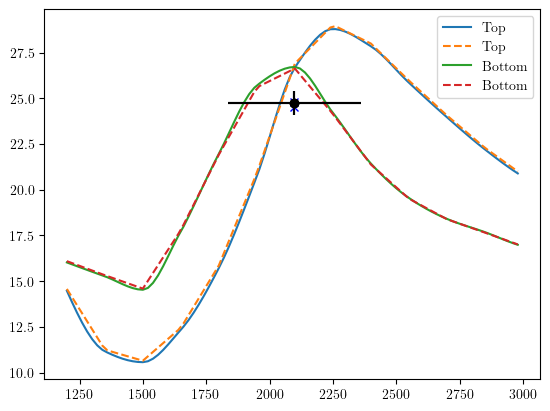

In [9]:
lam_grid = np.arange(1200., 3000., 20.)*u.AA

for cone_type in cone_types:
    i, j, k = np.unravel_index(np.argmin(chi2_map[wid][cone_type], axis=None), chi2_map[wid][cone_type].shape)
    plt.plot(lam_grid, 100*pws[cone_type].p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)), label=cone_type)
    plt.plot(lam_grid, 100*pws_linear[cone_type].p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)), label=cone_type, linestyle='dashed')

    for bname in op.pfrac[wid].keys():
        plt.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color='k')

        #p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i]], [cang_grid[j]], [iang_grid[k]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
        #plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')
        p_mod = pws[cone_type].p_bb(bands.bp[bname], tang_grid[i:i+1], cang_grid[j:j+1], iang_grid[k:k+1], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
        plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')

plt.legend()

In [12]:
#Set the additional SKIRTOR models we want to plot for W0204-0506
other_sk_models = [
    {"d03_mod":"MW"},
    {"d03_mod":"LMC"},
    {"d03_mod":"SMC"},
    #{"gs_min":0.005, "gs_max":0.25, "a":3.5},
    {"gs_min":1, "gs_max":10, "a":3.5, "sil":True},
    #{"gs_min":0.1, "gs_max":1, "a":0.0},
    #{"gs_min":0.1, "gs_max":1, "a":3.5},
    #{"gs_min":0.1, "gs_max":1, "a":3.5, "sil":True},
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "sil":True},
]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    other_sk.append(LoadSKIRTOR_General(**oskm, interp_method='linear'))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)

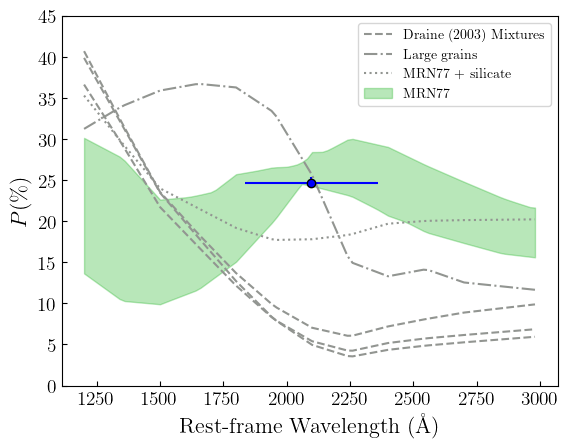

In [13]:
fig, ax = plt.subplots(1)#, figsize=(10,4))
plt.subplots_adjust(wspace=0., hspace=0.)

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

lam_grid = np.arange(1200., 3000., 20.)*u.AA

#labels = ['Draine (2003) Mixtures', None, None, 'Small grains graphite only', 'Large grains', 'MRN77 + silicate']
labels = ['Draine (2003) Mixtures', None, None, 'Large grains', 'MRN77 + silicate']
for mm, osk in enumerate(other_sk):
    kk = np.argmin(other_chi2[mm])
    ls = 'dashed'
    if mm==3:
        ls = 'dashdot'
    elif mm==4:
        ls = 'dotted'
    ax.plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:grey',ls=ls, label=labels[mm])
    
min_curve = np.zeros(len(lam_grid)) + 1e32
max_curve = np.zeros(len(lam_grid))
for cone_type in cone_types:
    for ind in np.argwhere(chi2_map[wid][cone_type]<1.0):
        i1, j1, k1 = ind
        #curve = 100*pws[cone_type].p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
        curve = 100*pws_linear[cone_type].p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
        min_curve = np.where(curve<min_curve, curve, min_curve)
        max_curve = np.where(curve>max_curve, curve, max_curve)
ax.fill_between(lam_grid.value, min_curve, max_curve, color='xkcd:green', alpha=0.3, label='MRN77')

for bname in op.pfrac[wid].keys():

    ax.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c='blue', markeredgecolor='black')

ax.legend()#loc=(0.67, 0.7))

ax.set_ylim([0., 45.])

ax.set_ylabel(r"$P (\%)$", fontsize=16)
ax.set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$", fontsize=16)

fig.savefig("SKIRTOR_W0204.png", dpi=200, bbox_inches='tight')

In [14]:
print(len(tang_grid), len(cang_grid), len(iang_grid))
print(chi2_map[wid][cone_types[0]].shape)

71 91 131
(71, 91, 131)


In [15]:
iang_grid

<Quantity [25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5,
           30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5, 34. , 34.5,
           35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. , 39.5,
           40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5,
           45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5,
           50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
           55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5,
           60. , 60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. , 64.5,
           65. , 65.5, 66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5,
           70. , 70.5, 71. , 71.5, 72. , 72.5, 73. , 73.5, 74. , 74.5,
           75. , 75.5, 76. , 76.5, 77. , 77.5, 78. , 78.5, 79. , 79.5,
           80. , 80.5, 81. , 81.5, 82. , 82.5, 83. , 83.5, 84. , 84.5,
           85. , 85.5, 86. , 86.5, 87. , 87.5, 88. , 88.5, 89. , 89.5,
           90. ] deg>

In [16]:
diang = np.mean(iang_grid[1:]-iang_grid[:-1]).value
iang_grid_extended = np.arange(-90., 90.1, diang)
#iang_grid_extended = np.concatenate([-iang_grid[::-1], iang_grid])
nie = len(iang_grid_extended)

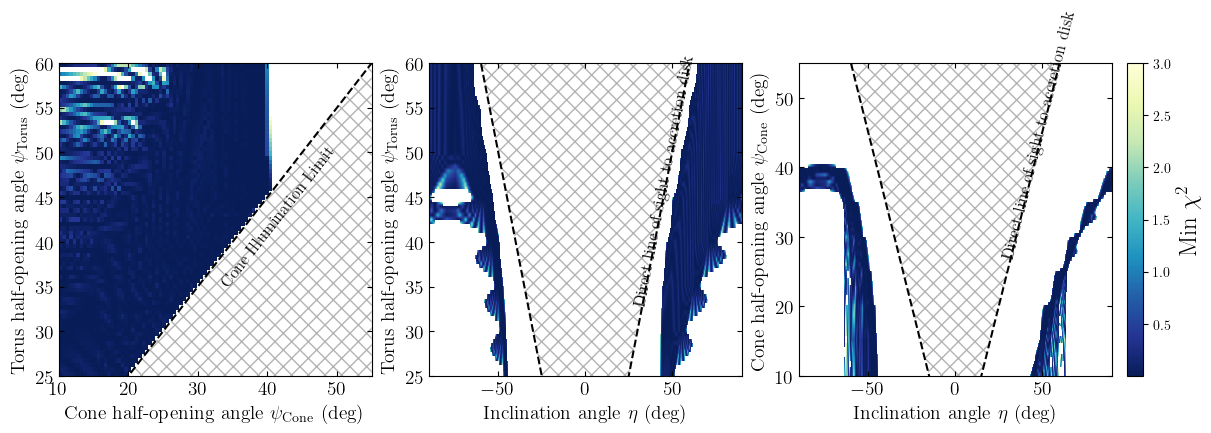

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), layout='constrained')
for ax in axs.flatten():
   ax.tick_params(axis='both', direction='in', labelsize=14, bottom=True, top=True, left=True, right=True)

axis_label_fontsize = 14

nt, nc, ni = chi2_map[wid][cone_types[0]].shape

diang = np.mean(iang_grid[1:]-iang_grid[:-1]).value
iang_grid_extended = np.arange(-90., 90.1, diang)*u.deg
#iang_grid_extended = np.concatenate([-iang_grid[::-1], iang_grid])
nie = len(iang_grid_extended) 

chi2_use = np.ma.zeros((nt, nc, nie))
chi2_use.mask = np.zeros(chi2_use.shape, dtype=bool)

chi2_use[:,:,:ni] = np.copy(chi2_map[wid][cone_types[1]][:,:,::-1])
chi2_use[:,:,nie-ni:] = np.copy(chi2_map[wid][cone_types[0]])
chi2_use.mask[:,:,ni:nie-ni] = True

vmin = np.min(chi2_use)
vmax = 3.0
cmap = 'YlGnBu_r'

II, JJ, KK = np.meshgrid(tang_grid.value, cang_grid.value, iang_grid_extended.value, indexing='ij')
chi2_use.mask[(JJ+5>II) | (np.abs(KK)<II)] = True
chi2_use.mask[chi2_use>vmax] = True

#Torus - Cone
ax = axs[0]
chi2_aux = np.min(chi2_use, axis=2)
cb = ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(cang_grid.value), np.max(cang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())+5, 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim())+5, ax.get_ylim()[0], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.set_xlabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(33, 35, "Cone Illumination Limit", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

#Torus - Inclination
ax = axs[1]
chi2_aux = np.min(chi2_use, axis=1)
ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid_extended.value), np.max(iang_grid_extended.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--') 
ax.plot(ax.get_xlim(), -np.array(ax.get_xlim()), 'k--') 
#ax.fill_between(ax.get_xlim(), -np.array(ax.get_xlim()), np.array(ax.get_xlim()), color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.fill_betweenx(ax.get_ylim(), -np.array(ax.get_ylim()), np.array(ax.get_ylim()), color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.set_xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(28, 33, "Direct line of sight to accretion disk", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

#Cone - Inclination
ax = axs[2]
chi2_aux = np.min(chi2_use, axis=0)
cb = plt.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid_extended.value), np.max(iang_grid_extended.value), np.min(cang_grid.value), np.max(cang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())-5, 'k--') 
ax.plot(ax.get_xlim(), -np.array(ax.get_xlim())-5, 'k--') 
#ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim())-5, ax.get_ylim()[1], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.fill_betweenx(ax.get_ylim(), -np.array(ax.get_ylim())-5, np.array(ax.get_ylim())+5, color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
plt.xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
plt.ylabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(27, 27, "Direct line of sight to accretion disk", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

fig.colorbar(cb, fraction=0.05).set_label(label=r'Min $\chi^2$',size=18)

plt.show()
fig.savefig("W0204_chi2maps.png", dpi=200, bbox_inches='tight')